# Functions for Wilks Statistical Testing
### Packages

In [1]:
import numpy as np
from scipy import stats
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import datetime as dt
import pandas as pd

### Functions

In [2]:
## Calculation for t-test p-value
def t_test_two_means(m1,m2,std1,std2,n1,n2,test_type,diff):
    '''
    This function calculates the p-values for a small sample test for the difference between two means. 
    Assumes null hypothesis can be:
    • µ1 - µ2 ≤ ∆
    • µ1 - µ2 ≥ ∆
    • µ1 - µ2 = ∆

    Inputs
    m1: sample 1 mean(s) 
    m2: sample 2 mean(s)
    std1: sample 1 standard deviation(s)
    std2: sample 2 standard deviation(s)
    n1: sample 1 size(s)
    n2: sample 2 size(s)
    test_type: whether the test is one (1) or two tailed (2)
    diff: diff between population means (∆)

    Outputs
    pvalue: pvalues
    '''

    # Calculate t-statistic
    tstat = (m1-m2-diff)/np.sqrt(((std1**2)/n1)+((std2**2)/n2))

    # Calculate degrees of freedom and round down
    df = ((((std1**2)/n1)+((std2**2)/n2))**2)/(((((std1**2)/n1)**2)/(n1-1))+((((std2**2)/n2)**2)/(n2-1)))
    df = np.floor(df)

    # Calculate & return p-value
    pvalue = stats.t.sf(abs(tstat),df=df)*test_type
    return pvalue

In [3]:
## Calculation of Wilks p-critical value
def Wilks_pcrit(pvalues, siglevel):
    '''
    This function calcules the p-critical level for the Wilks significance test

    Inputs
    pvalues: array of p-values
    siglevel: significance level (i.e. 0.01 or 1%, 0.05 or 5%, ...)
    
    Outputs
    pcrit: Wilks p-critical value (i.e. any p-value less than this is significant)
    '''

    # Calculate false detection rate
    alpha_fdr = 2*siglevel

    # Flatten p-values into 1D array & sort
    pvalues_fl = pvalues.flatten()
    pvalues_fl = np.sort(pvalues_fl)

    # Generate arrays to calculate differences
    x = np.arange(1,len(pvalues_fl)+1,1)
    x = x.astype(float)
    y = (x/len(x))*alpha_fdr

    # Calculate differences
    d = pvalues_fl-y

    # Grab index of first p-value where p-value > y
    k = np.where(d>0)[0][0]

    # Find p-critical value & return it
    pcrit = pvalues_fl[k-1]
    return pcrit

### Example
Seeing if surface temperature (1981-2010) has changed significantly from pre-industrial (1850-1900)

In [4]:
# Load air temperature data
airtemp_ds = xr.open_dataset('air.2m.mon.mean.nc')

# Calculate pre-industrial average & standard deviation
temp_data_pi_avg = airtemp_ds.air.loc[dict(time=slice("1850-01-01","1900-12-01"))].mean('time')
temp_data_pi_std = airtemp_ds.air.loc[dict(time=slice("1850-01-01","1900-12-01"))].std('time')
n_pi = 51*12

# Calculate current average & standard deviation
temp_data_cur_avg = airtemp_ds.air.loc[dict(time=slice("1981-01-01","2010-12-01"))].mean('time')
temp_data_cur_std = airtemp_ds.air.loc[dict(time=slice("1981-01-01","2010-12-01"))].std('time')
n_cur = 30*12

In [5]:
# Calculate p-values
pvals = t_test_two_means(temp_data_pi_avg,temp_data_cur_avg,temp_data_pi_std,temp_data_cur_std,n_pi,n_cur,2,0)

# Add p-values to one of the data arrays
temp_data_cur_avg = temp_data_cur_avg.to_dataset()
temp_data_cur_avg['pvals'] = (('lat','lon'),pvals)

# Calculate p-critical at 5%
pcrit = Wilks_pcrit(pvals,0.05)

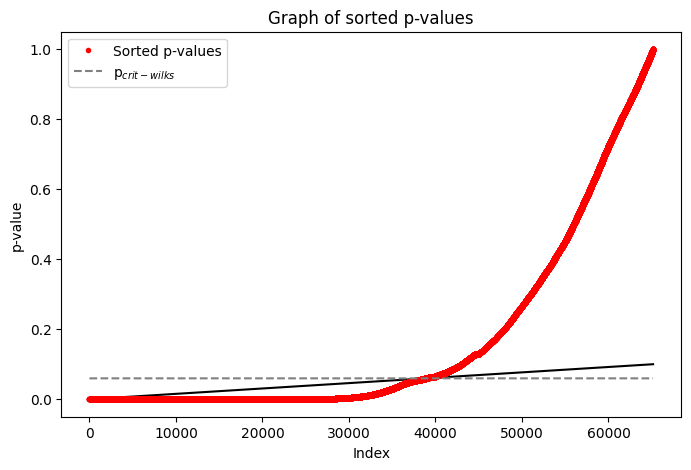

In [6]:
## Graph of sorted p-values
# Data analysis
pvals_flat = np.sort(pvals.flatten()) # Flatten & sort p-values

x = np.arange(1,len(pvals_flat)+1,1) # Generate array of indices
x = x.astype(float)
y = (x/len(x))*0.1 

# Set up
fig, axlist = plt.subplots(1,1)
fig.set_size_inches(8,5)

# Plot data
axlist.plot(x,y,'-k')
axlist.plot(x,pvals_flat,'.r',markersize=6,label='Sorted p-values')
axlist.plot(x,np.full(x.shape,pcrit),'--',color='gray',label='p$_{crit-wilks}$')

# Formatting
axlist.set_xlabel('Index')
axlist.set_ylabel('p-value')
axlist.set_title('Graph of sorted p-values')
axlist.legend()

Text(0.5, 0.98, 'Difference between pre-industrial (1850-1900) and current (1981-2010)\nsurface air temperature')

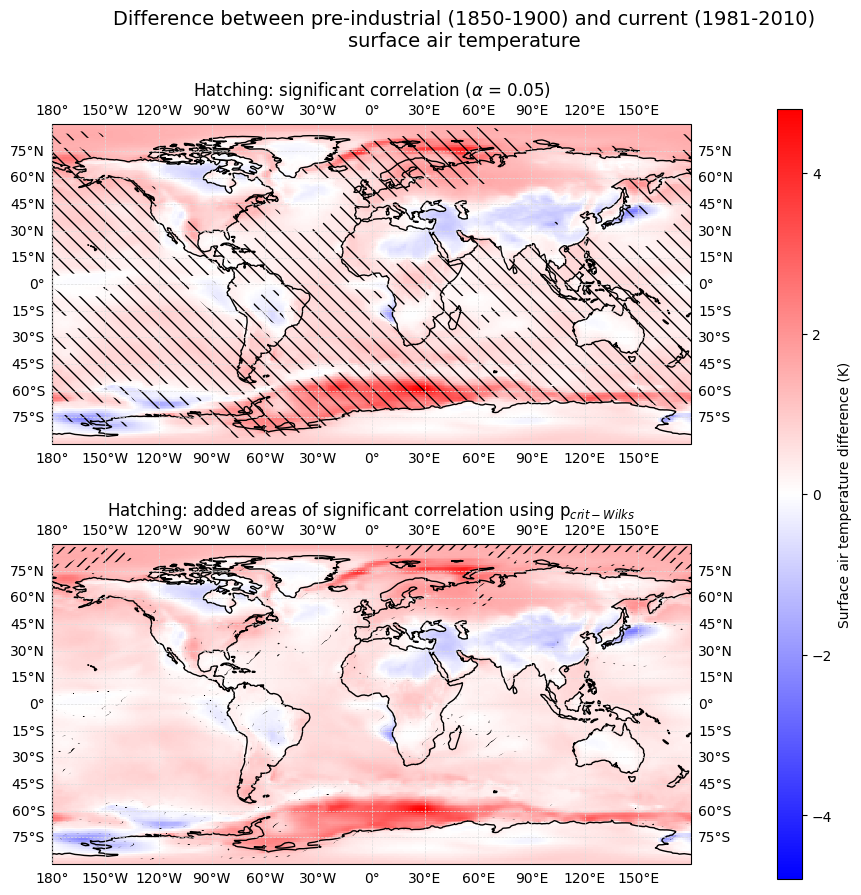

In [7]:
## Graphs of significant correlation with and without Wilks
# Set-up
fig2, axlist2 = plt.subplots(2,1,subplot_kw=dict(projection=ccrs.PlateCarree()))
fig2.set_size_inches(11,10)

# Plot data
cax = (temp_data_cur_avg-temp_data_pi_avg).air.plot(
    ax=axlist2[0],transform=ccrs.PlateCarree(),
    cmap=plt.cm.bwr,add_colorbar=False,zorder=1)
axlist2[0].coastlines(zorder=2)
temp_data_cur_avg.pvals.plot.contourf(
    ax=axlist2[0],levels=[-0.01,0.05,1],hatches=['\\\\',None],colors='none',
    add_colorbar=False,transform=ccrs.PlateCarree(),zorder=3)

(temp_data_cur_avg-temp_data_pi_avg).air.plot(
    ax=axlist2[1],transform=ccrs.PlateCarree(),
    cmap=plt.cm.bwr,add_colorbar=False,zorder=1)
axlist2[1].coastlines(zorder=2)
temp_data_cur_avg.pvals.plot.contourf(
    ax=axlist2[1],levels=[0.05,pcrit,1],hatches=[None,'///',None],colors='none',
    add_colorbar=False,transform=ccrs.PlateCarree(),zorder=3)

# Formatting
axlist2[0].gridlines(crs=ccrs.PlateCarree(),zorder=4, # Transform to projection, layer order
    linewidth=0.5,color='#dddddd',linestyle='--', # Line width, color, style
    xlocs=range(-180,180,30),ylocs=range(-90,90,15), # x, y label range
    draw_labels=True) # Draw labels
axlist2[0].set_title(r'Hatching: significant correlation ($\alpha$ = 0.05)')

axlist2[1].gridlines(crs=ccrs.PlateCarree(),zorder=4, # Transform to projection, layer order
    linewidth=0.5,color='#dddddd',linestyle='--', # Line width, color, style
    xlocs=range(-180,180,30),ylocs=range(-90,90,15), # x, y label range
    draw_labels=True) # Draw labels
axlist2[1].set_title('Hatching: added areas of significant correlation using p$_{crit-Wilks}$')

fig2.colorbar(cax,ax=axlist2[0:2],pad=0.1,label='Surface air temperature difference (K)',aspect=30)

fig2.suptitle('Difference between pre-industrial (1850-1900) and current (1981-2010)\nsurface air temperature',fontsize=14)
